# Chapter 5 - Indoor Scene Classification with TFLu and the Arduino Nano

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


### Python libraries

In [31]:
import numpy as np
import pathlib
#!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
import tensorflow as tf
#import tensorflow_datasets as tfds
import zipfile
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

### Constants

In [4]:
MODEL_ALPHA = 0.35
MODEL_INPUT_WIDTH = 48
MODEL_INPUT_HEIGHT = 48
TFL_MODEL_FILE = "indoor_scene_recognition.tflite"
TFL_MODEL_HEADER_FILE = "indoor_scene_recognition_model.h"
TF_MODEL = "indoor_scene_recognition"

## Transfer learning with Keras

### Unzip the dataset (dataset.zip) SKIP THIS STEP


In [5]:
# with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
#   zip_ref.extractall(".")
# data_dir = "dataset"

### Prepare the train (80%) and validation (20%) datasets

In [6]:
data_dir="dataset"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

Found 151 files belonging to 4 classes.
Using 121 files for training.
Found 151 files belonging to 4 classes.
Using 30 files for validation.


2023-06-29 17:11:43.622449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-29 17:11:43.622545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-06-29 17:11:43.622590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-06-29 17:11:43.622634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-06-29 17:11:43.622692: W tensorfl

### Get the name of the classes

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['paper', 'rock', 'scissors', 'unknown']


### Rescale the pixel values from [0, 255] tp [-1, 1]

In [8]:
rescale = tf.keras.layers.Rescaling(1./255, offset= -1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds   = val_ds.map(lambda x, y: (rescale(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Import the MobileNet v2 pre-trained model

In [32]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
base_model = MobileNetV2(input_shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3),
                         include_top=False,
                         weights='imagenet',
                         alpha=0.35)
base_model.trainable = False

feat_extr = base_model

### Augment the input data

In [33]:
augmen = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
])

train_ds = train_ds.map(lambda x, y: (augmen(x), y))
val_ds   = val_ds.map(lambda x, y: (augmen(x), y))

### Prepare the classification head

In [34]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

### Build the model architecture

In [35]:
inputs = tf.keras.Input(shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3))
x = global_avg_layer(feat_extr.layers[-1].output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = dense_layer(x)
model = tf.keras.Model(inputs=feat_extr.inputs, outputs=outputs)

### Compile the model with a 0.0005 learning rate

In [36]:
lr = 0.0005
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

### Model summary

In [37]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 16)   432         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 24, 24, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 24, 24, 16)   0           ['bn_Conv1[0][0]']               
                                                                                            

### Train the model with 10 epochs

Epoch 1/50
4/4 [==============================] - 5s 830ms/step - loss: 1.7497 - accuracy: 0.2479 - val_loss: 1.7677 - val_accuracy: 0.3000
Epoch 2/50
4/4 [==============================] - 2s 618ms/step - loss: 1.4712 - accuracy: 0.3554 - val_loss: 1.4995 - val_accuracy: 0.5667
Epoch 3/50
4/4 [==============================] - 2s 732ms/step - loss: 1.6463 - accuracy: 0.3140 - val_loss: 1.5736 - val_accuracy: 0.3333
Epoch 4/50
4/4 [==============================] - 2s 534ms/step - loss: 1.4875 - accuracy: 0.3058 - val_loss: 1.3266 - val_accuracy: 0.3667
Epoch 5/50
4/4 [==============================] - 2s 679ms/step - loss: 1.4390 - accuracy: 0.3636 - val_loss: 1.6175 - val_accuracy: 0.1667
Epoch 6/50
4/4 [==============================] - 2s 592ms/step - loss: 1.4062 - accuracy: 0.3802 - val_loss: 1.4551 - val_accuracy: 0.3333
Epoch 7/50
4/4 [==============================] - 2s 505ms/step - loss: 1.2933 - accuracy: 0.4050 - val_loss: 1.4035 - val_accuracy: 0.3333
Epoch 8/50
4/4 [====

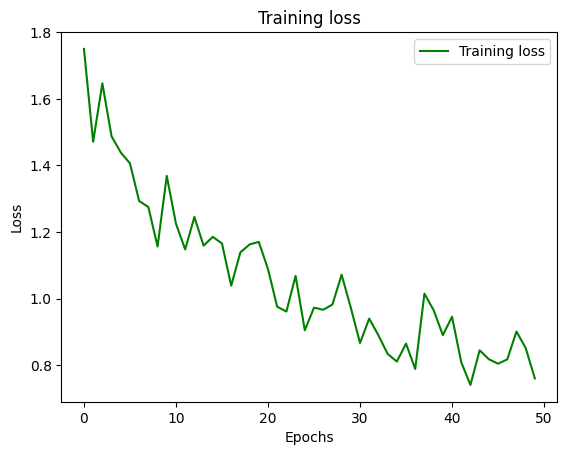

In [38]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

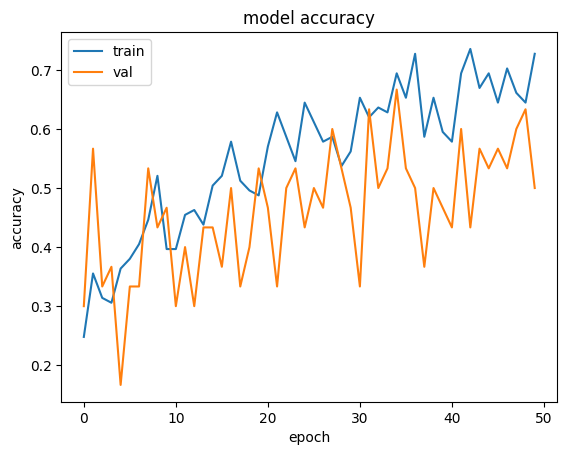

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

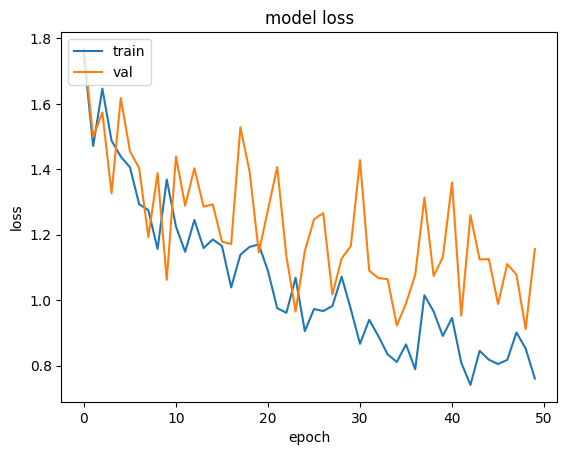

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save the TensorFlow model

In [41]:
model.save(TF_MODEL)

INFO:tensorflow:Assets written to: indoor_scene_recognition/assets


INFO:tensorflow:Assets written to: indoor_scene_recognition/assets


## Preparing and testing the quantized TFLite model

### Unzip the test dataset (test_samples.zip)

In [ ]:
with zipfile.ZipFile("test_samples.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
test_dir = "dataset"

### Rescale the pixel values from [0, 255] to [-1, 1]

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      interpolation="bilinear",
                                                      image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

### Quantize the TensorFlow model with the TFLite converter

In [30]:
repr_ds = test_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
    yield [i_value]

converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8

tfl_model = converter.convert()

NameError: name 'test_ds' is not defined

### Get the TFLite model size in bytes

In [ ]:
size_tfl_model = len(tfl_model)
print(len(tfl_model), "bytes")

### Initialize the TFLite interpreter

In [ ]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tfl_model)

# Allocate the tensors
interpreter.allocate_tensors()

### Get input quantization parameters

In [ ]:
# Get input/output layer information
i_details = interpreter.get_input_details()[0]
o_details = interpreter.get_output_details()[0]

# Get input quantization parameters.
i_quant = i_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]

### Evaluate the accuracy of the quantized TFLite model

In [ ]:
test_ds0 = val_ds.unbatch()

num_correct_samples = 0
num_total_samples   = len(list(test_ds0.batch(1)))

for i_value, o_value in test_ds0.batch(1):
  i_value = (i_value / i_scale) + i_zero_point
  i_value = tf.cast(i_value, dtype=tf.int8)
  interpreter.set_tensor(i_details["index"], i_value)
  interpreter.invoke()
  o_pred = interpreter.get_tensor(o_details["index"])[0]

  if np.argmax(o_pred) == o_value:
    num_correct_samples += 1

print("Accuracy:", num_correct_samples/num_total_samples)

### Convert the TFLite model to C-byte array with xxd

In [ ]:
open("model.tflite", "wb").write(tfl_model)
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i model.tflite > indoor_scene_recognition.h